# Solow model with human capital

Imports and set magics:

In [365]:
# Imports required to read the code
import numpy as np
from scipy import optimize
import sympy as sm
from sympy import *
import random

# Imports required to plot
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Local modules
import modelproject as mp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Description of the Solow model with human capital

The Solow model with human capital contains the following variables:
1. $K_t$ is physical capital
2. $H_t$ is human capital
3. $L_t$ is labor (growing with a constant rate of $n$)
4. $A_t$ is technology (growing with a constant rate of $g$)
5. $Y_t = F(K_t,H_t,A_tL_t)$ is GDP
6. $s_K$ is the savings rate for physical capital
7. $s_H$ is the savings rate for human capital

The Solow model with human capital is defined by the following equations:

The Cobb-Douglas production function:
$$ Y_{t} = F(K_{t},H_{t},A_{t}L_{t})=K_{t}^{\alpha}H_{t}^{\phi}(A_{t}L_{t})^{1-\alpha-\phi} $$
  where
  $$ 0<\alpha<1$$ 
  $$0<\phi<1$$
  $$\alpha+\phi<1  $$
with growth in labor and technology given by:
$$ L_{t+1}=(1+n)L_{t}$$
$$ A_{t+1}=(1+g)A_{t}$$


Saving of human and physical capital as a constant fraction of GDP:
$$ S_t = (s_{K}+s_{H})Y_t $$
  where
  $$ s_{K}+s_{H} <1 $$

Capital accumulation for physical capital:
$$ K_{t+1} = s_{K}Y_{t}+(1-\delta)K_{t}$$

Capital accumulation for human capital:
$$ H_{t+1} = s_{H}Y_{t}+(1-\delta)H_{t}$$

Technological adjusted variables are given by:
$$\tilde{k}_t = \frac{K_t}{A_{t}L_{t}}$$
$$\tilde{h}_t = \frac{H_t}{A_{t}L_{t}}$$
$$\tilde{y}_t = \frac{Y_t}{A_{t}L_{t}} = \frac{K_{t}^{\alpha}H_{t}^{\phi}(A_{t}L_{t})^{1-\alpha-\phi}}{A_{t}L_{t}} = \tilde{k}_t^\alpha \tilde{h}_t^\phi$$
which implies that the productions function has constant return to scale.

The transition equation for physical capital:
$$\tilde{k}_{t+1}=\frac{1}{(1+n)(1+g)}[s_{K}\tilde{k}_t^\alpha \tilde{h}_t^\phi+(1-\delta)\tilde{k}_t]$$

The transition equation for human capital:
$$\tilde{h}_{t+1}=\frac{1}{(1+n)(1+g)}[s_{H}\tilde{k}_t^\alpha \tilde{h}_t^\phi+(1-\delta)\tilde{h}_t]$$

## Analytical solution

I define the the variables using Sympy:

In [366]:
k = sm.symbols('k')
h = sm.symbols('h')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
s_K = sm.symbols('s_K')
s_H = sm.symbols('s_H')
g = sm.symbols('g')
n = sm.symbols('n')

Set up transition equation for physical capital and solve:

In [367]:
# Define f(k*h*)
f = k**alpha*h**phi

# Define steady state for physical capital 
ss_K = sm.Eq(k,(s_K*f+(1-delta)*k)/((1+n)*(1+g)))

# Solve steady state for k
kss = sm.solve(ss_K,k)[0]

# Display solution 
kss 

((delta + g*n + g + n)/(h**phi*s_K))**(1/(alpha - 1))

Set up transition equation for human capital and solve:

In [368]:
# Define steady state for human capital
ss_H = sm.Eq(h,(s_H*f+(1-delta)*h)/((1+n)*(1+g)))

# Solve steady state for h
hss = sm.solve(ss_H,h)[0]

# Display solution 
hss

((delta + g*n + g + n)/(k**alpha*s_H))**(1/(phi - 1))

I turn the Sympy-functions into Python-functions using lambdify to find the steady state values:

In [369]:
# ss_k-function with 7 arguments 
ss_func_k = sm.lambdify((s_K, s_H,g,n,delta,alpha, phi),kss)

# Evaluate functions
ss_func_k(0.2,0.1,0.02,0.01,0.075,1/3, 1/3)

2.6213281042763*h**0.5

In [370]:
# ss_h-function with 7 arguments 
ss_func_h = sm.lambdify((s_K, s_H,g,n,delta,alpha, phi),hss)

# Evaluate function
ss_func_h(0.15,0.1,0.02,0.01,0.075,1/3, 1/3)

0.926779439124325*k**0.5

## Numerical solution

### Algorithm

The algorithm contains 4 steps:
1. Initialize the parameters of the model given by the saving rate in physical and human capital, $s_K$ and $s_H$, the growth in technology, $g$, the growth in population, $n$, return on physical and human capital, $\alpha$ and $\phi$, and the depriciation rate, $\delta$.

2. Set the function for the Solow equations, given by an equation for physical capital and an equation for human capital.
    - Set the variables and parameters contained in the equations
    - Define the Solow equations for $\tilde{k}$ and $\tilde{h}$

3. Set up a for-loop and call the solver
    - Set initial guess for the values of $\tilde{k}$ and $\tilde{h}$
    - Create empty lists for the solutions
    - Set up a for-loop 
    - Call the optimize.root solver
    - Append the solutions to the lists

4. Display the result
    - Solve the model for the given parameter values
    - Print the solution


In [371]:
# Step 1: Initialize the baseline parameters 
s_K = 0.15
s_H = 0.10
g = 0.02
n = 0.01
alpha = 1/3
phi = 1/3
delta = 0.075

In [372]:
# Step 2: Set the Solow equations
def solow_equations(vars , s_K, s_H, n , g, delta, alpha, phi):

    k_tilde , h_tilde = vars

    solow_k = (s_K * k_tilde**alpha * h_tilde**phi - (delta + n + g + n*g)*k_tilde)/((1+n)*(1+g))
    solow_h = (s_H * k_tilde**alpha * h_tilde**phi - (delta + n + g + n*g)*h_tilde)/((1+n)*(1+g))

    return solow_k , solow_h

In [373]:
# Step 3: Set up the for-loop and call the solver
def ss_solve(fun=solow_equations, x0=None, args=None, method='hybr'):
    # Initial guess range for k_tilde and h_tilde
    initial_guesses = [(1.0, 1.0), (2.0, 2.0), (3.0, 3.0)] 

    # Lists to store solutions for k_tilde and h_tilde
    k_tilde_solutions = []
    h_tilde_solutions = []

    # Iterate over initial guesses and solve the Solow equations
    for initial_guess in initial_guesses:
        solution = optimize.root(solow_equations, initial_guess, args=(s_K, s_H, n, g, delta, alpha, phi), method='hybr')
    
        if solution.success:
            k_tilde_solution, h_tilde_solution = solution.x
            k_tilde_solutions.append(k_tilde_solution)
            h_tilde_solutions.append(h_tilde_solution)
        else:
            print("Optimization failed for initial guess:", initial_guess)
    
    return k_tilde_solutions , h_tilde_solutions



In [374]:
# Step 4: Display solution:

# Solve the model for given parameter values using the scipy.optimize.root
k_tilde_solutions, h_tilde_solutions = ss_solve(fun=solow_equations, x0 = initial_guesses, args =(s_K, s_H, n, g, delta, alpha, phi), method='hybr' )

solutions = zip(k_tilde_solutions,h_tilde_solutions)

# Print solutions
for i, solution in enumerate(solutions, start=1):
    print(f"Solution {i} (k_tilde, h_tilde):", solution)

Solution 1 (k_tilde, h_tilde): (1.9325702897630859, 1.2883801931753904)
Solution 2 (k_tilde, h_tilde): (1.9325702897630959, 1.2883801931753975)
Solution 3 (k_tilde, h_tilde): (1.9325702897630987, 1.288380193175399)


# Further analysis

### Plot the steady state

In [375]:
# Define the null-clines 
def null_k(k_tilde, alpha, phi, delta, g, n, s_K):
    return (k_tilde**(1 - alpha)*(delta + g*n + g + n)/s_K)**(1/phi)

def null_h(k_tilde, alpha, phi, delta, g, n, s_H):
    return ((delta + g*n + g + n)/(k_tilde**alpha*s_H))**(1/(phi - 1))

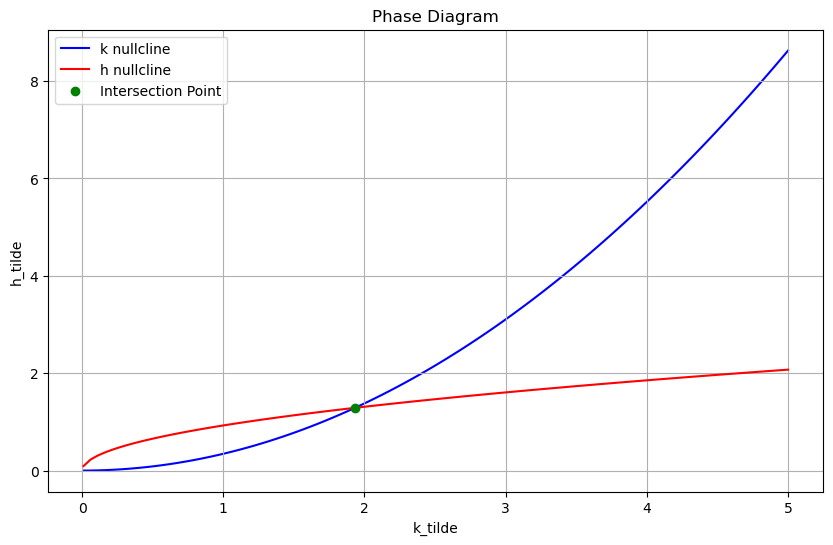

In [376]:
# Define the range of k_tilde values
k_tilde_values = np.linspace(0.01, 5, 100)

# Calculate null-clines for given parameters values
k_nullcline = null_k(k_tilde_values, alpha, phi, delta, g, n, s_K)
h_nullcline = null_h(k_tilde_values, alpha, phi, delta, g, n, s_H)

# Plot the phase diagram
plt.figure(figsize=(10, 6))
plt.plot(k_tilde_values, k_nullcline, label='k nullcline', color='blue', zorder=1)
plt.plot(k_tilde_values, h_nullcline, label='h nullcline', color='red', zorder=2)
plt.scatter(1.9325702897630954, 1.288380193175397, color='green', label='Intersection Point', zorder=3)
plt.xlabel('k_tilde')
plt.ylabel('h_tilde')
plt.title('Phase Diagram')
plt.legend()
plt.grid(True)
plt.show()

### Shock to the model

I analyse how an increase in savings rate in human capital of 20%, corresponding to a new value of 0.12, affects the phase diagram.

In [377]:
#Define the increase in s_H:
s_H = 0.12

# Solve the model for given parameter values using the scipy.optimize.root
k_tilde_solutions, h_tilde_solutions = ss_solve(fun=solow_equations, x0 = initial_guesses, args =(s_K, s_H, n, g, delta, alpha, phi), method='hybr' )

solutions = zip(k_tilde_solutions,h_tilde_solutions)

# Print solutions
for i, solution in enumerate(solutions, start=1):
    print(f"Solution {i} (k_tilde, h_tilde):", solution)

Solution 1 (k_tilde, h_tilde): (2.319084347715707, 1.855267478172566)
Solution 2 (k_tilde, h_tilde): (2.3190843477157146, 1.8552674781725718)
Solution 3 (k_tilde, h_tilde): (2.319084347715714, 1.855267478172571)


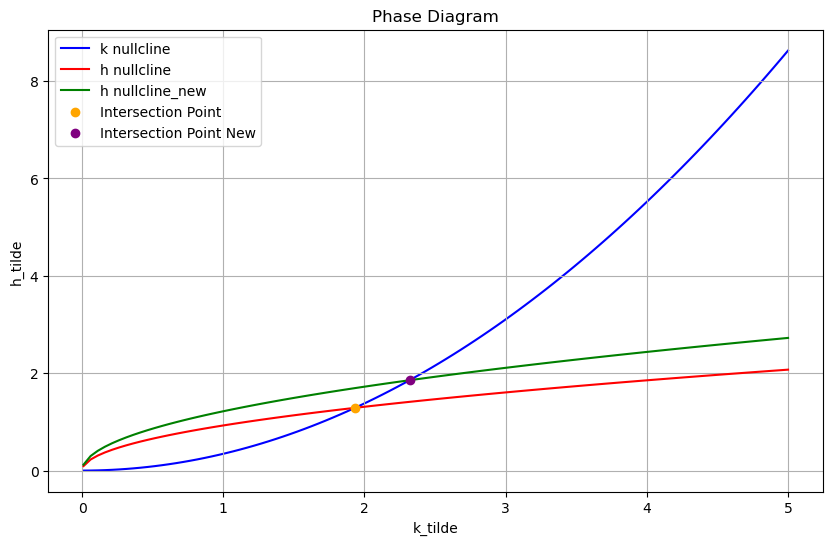

In [378]:
# Define the range of k_tilde values
k_tilde_values = np.linspace(0.01, 5, 100)

# Calculate null-clines for given parameters values
k_nullcline = null_k(k_tilde_values, alpha, phi, delta, g, n, s_K)
h_nullcline = null_h(k_tilde_values, alpha, phi, delta, g, n, 0.10)
h_nullcline_new = null_h(k_tilde_values, alpha, phi, delta, g, n, 0.12)

# Plot the phase diagram
plt.figure(figsize=(10, 6))
plt.plot(k_tilde_values, k_nullcline, label='k nullcline', color='blue', zorder=1)
plt.plot(k_tilde_values, h_nullcline, label='h nullcline', color='red', zorder=2)
plt.plot(k_tilde_values, h_nullcline_new, label='h nullcline_new', color='green', zorder=3)
plt.scatter(1.9325702897630954, 1.288380193175397, color='orange', label='Intersection Point', zorder=4)
plt.scatter(2.319084347715714, 1.855267478172571, color='purple', label='Intersection Point New', zorder=5)
plt.xlabel('k_tilde')
plt.ylabel('h_tilde')
plt.title('Phase Diagram')
plt.legend()
plt.grid(True)
plt.show()

An increase in the savings rate of human capital will increase human capital. When human capital increase the workers become more efficient, which will lead to an increase in GDP. 


## Extenting the Solow model with human capital to include R&D

I extend the Solow model with human capital by adding R&D, shown by having to different types of labor. This implies changes to the production function and the capital accumulation equations for both physical and human capital.

The Solow model with human capital and R&D contains the following variables:
1. $K_t$ is phisical capital
2. $H_t$ is human capital
3. $L_{t}$ is labor (growing with a constant rate of $n$)
4. $L_{Yt}$ is production labor
5. $L_{At}$ is research labor
6. $A_t$ is technology (depending on research labor)
7. $Y_t = F(K_t,A_tL_t)$ is GDP
8. $s_K$ is the savings rate for physical capital
9. $s_H$ is the savings rate for human capital
10. $s_R$ is the share of the total population who are research labor 

The Solow model with human capital is defined by the following equations:

The Cobb-Douglas production function:
$$ Y_{t} = F(K_{t},H_{t},A_{t}L_{Yt})=K_{t}^{\alpha}H_{t}^{\phi}(A_{t}L_{Yt})^{1-\alpha-\phi} $$
  where
  $$ 0<\alpha<1$$ 
  $$0<\phi<1$$
  $$\alpha+\phi<1  $$
with growth in the total labor force and technology given by:
$$ L_{t+1}=(1+n)L_{t}$$
$$ A_{t+1}=\rho A_{t}^{\sigma} L_{At}^{\lambda}+A_{t}$$
where
$$ \rho >0 $$
$$ \sigma >0 $$
$$ 0=<\lambda<1 $$

The share of research labor is given by:
$$ L_{At}=s_{R}L_{t}$$
where
$$ 0<s_{R}<1$$

The total labor force is given by:
$$ L_{t}=L_{At}+L_{Yt} $$

Saving of human and physical capital as a constant fraction of GDP:
$$ S_t = (s_{K}+s_{H})Y_t $$
  where
  $$ s_{K}+s_{H} <1 $$

Capital accumulation for physical capital:
$$ K_{t+1} = s_{K}Y_{t}+(1-\delta)K_{t}$$

Capital accumulation for human capital:
$$ H_{t+1} = s_{H}Y_{t}+(1-\delta)H_{t}$$

Technological adjusted variables are given by:
$$\tilde{k}_t = \frac{K_t}{L_{Yt}}$$
$$\tilde{h}_t = \frac{H_t}{L_{Yt}}$$
$$\tilde{y}_t = \frac{Y_t}{L_{Yt}} = \frac{K_{t}^{\alpha}H_{t}^{\phi}(A_{t}L_{Yt})^{1-\alpha-\phi}}{L_{Yt}} = \tilde{k}_t^\alpha \tilde{h}_t^\phi A_t^{1-\alpha-\phi}$$

The transition equation for physical capital:
$$\tilde{k}_{t+1}=\frac{1}{(1+n)(1+g)}[s_{K}\tilde{k}_t^\alpha \tilde{h}_t^\phi (1-s_R)^{1-\alpha-\phi}+(1-\delta)\tilde{k}_t]$$

The transition equation for human capital:
$$\tilde{h}_{t+1}=\frac{1}{(1+n)(1+g)}[s_{H}\tilde{k}_t^\alpha \tilde{h}_t^\phi (1-s_R)^{1-\alpha-\phi}+ (1-\delta)\tilde{h}_t]$$

In [382]:
# Step 1: Initialize the baseline parameters 
s_K = 0.15
s_H = 0.10
g = 0.00
n = 0.01
alpha = 1/3
phi = 1/3
delta = 0.075
rho = 10
sigma = 0.9
lambd = 0.9
s_R = 0.2

In [383]:
# Step 2: Set the Solow equations
def solow_equations_new(vars_new , s_K, s_H, n , g, delta, alpha, phi, s_R):

    k_tilde , h_tilde = vars_new

    solow_k = (s_K * k_tilde**alpha * h_tilde**phi * (1-s_R)**(1-alpha-phi) - (delta + n + g + n*g)*k_tilde)/((1+n)*(1+g))
    solow_h = (s_H * k_tilde**alpha * h_tilde**phi * (1-s_R)**(1-alpha-phi) - (delta + n + g + n*g)*h_tilde)/((1+n)*(1+g))

    return solow_k , solow_h

In [384]:
def ss_solve_new(fun=solow_equations_new, x0=None, args=None, method='hybr'):
    # Initial guess range for k_tilde and h_tilde
    initial_guesses = [(1.0, 1.0), (2.0, 2.0), (3.0, 3.0)] 

    # Lists to store solutions for k_tilde and h_tilde
    k_tilde_solutions = []
    h_tilde_solutions = []

    # Iterate over initial guesses and solve the Solow equations
    for initial_guess in initial_guesses:
        solution = optimize.root(solow_equations_new, initial_guess, args=(s_K, s_H, n, g, delta, alpha, phi, s_R), method='hybr')
    
        if solution.success:
            k_tilde_solution, h_tilde_solution = solution.x
            k_tilde_solutions.append(k_tilde_solution)
            h_tilde_solutions.append(h_tilde_solution)
        else:
            print("Optimization failed for initial guess:", initial_guess)
    
    return k_tilde_solutions , h_tilde_solutions


In [385]:
# Solve the model for given parameter values using the scipy.optimize.root
k_tilde_solutions, h_tilde_solutions = ss_solve_new(fun=solow_equations, x0 = initial_guesses, args =(s_K, s_H, n, g, delta, alpha, phi, s_R), method='hybr' )

solutions = zip(k_tilde_solutions,h_tilde_solutions)

# Print solutions
for i, solution in enumerate(solutions, start=1):
    print(f"Solution {i} (k_tilde, h_tilde):", solution)

Solution 1 (k_tilde, h_tilde): (2.9309993893751263, 1.9539995929167513)
Solution 2 (k_tilde, h_tilde): (2.930999389375126, 1.953999592916751)
Solution 3 (k_tilde, h_tilde): (2.930999389375123, 1.9539995929167493)


# Conclusion

I have found the solution to the steady state for the Solow model with human capital and displayed the transition.
I have analyzed what happens, given a shock to one of the parameters of the model and displayed the new transition into steady staete.

I have extended the model to contain two types of labor, by adding research and development to the model. R&D implies that the growth in  technology depends on the R&D-labor, and hence the GDP and physical and human capital can no longer be adjusted for the technological development. 